# Example Usage
This notebook serves to demonstrate some of the key objects in the MKIDReadout Analysis package. The core idea is to start with a quasiparticle time stream object with photons and then apply this to an existing resonator oject using the measurment object. An example quasiparticle_timestream, resonator, and measurment is explored in this notebook.

In [1]:
import logging

import matplotlib.pyplot as plt

from mkidreadoutanalysis.mkidnoiseanalysis import plot_channel_fft, plot_psd, apply_lowpass_filter, compute_r
from mkidreadoutanalysis.resonator import *
from mkidreadoutanalysis.mkidreadout import MKIDReadout
import copy
%matplotlib inline

In [2]:
# Generate a timestream proportional to the change in quasiparticle density
quasiparticle_timestream = QuasiparticleTimeStream(fs = 2e6, ts = 1)

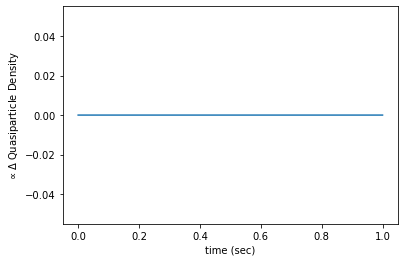

In [3]:
# Plot the raw data
quasiparticle_timestream.plot_timeseries(quasiparticle_timestream.data)

In [4]:
# Define a sudden change in quasiparticle density (caused by a photon)
quasiparticle_timestream.gen_quasiparticle_pulse(tf=30);

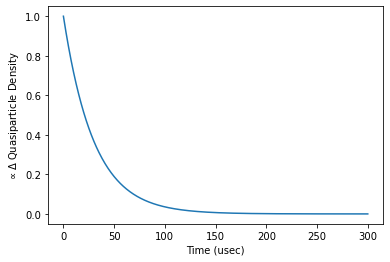

In [5]:
# Plot the pulse
quasiparticle_timestream.plot_pulse()

In [6]:
# Generate photon arrival times
quasiparticle_timestream.gen_photon_arrivals(cps=610)

array([False, False, False, ..., False, False, False])

In [7]:
# Verify how many photons we got
print(quasiparticle_timestream.photon_arrivals.sum())

608


In [8]:
# Populate phase data with photon pulses
quasiparticle_timestream.populate_photons()

array([0., 0., 0., ..., 0., 0., 0.])

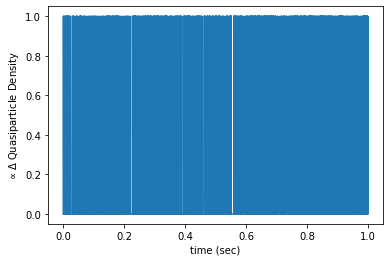

In [9]:
# Plot new timseries data
quasiparticle_timestream.plot_timeseries(quasiparticle_timestream.data)

# Resonator

In [10]:
# Create resonator and compute S21
resonator = Resonator(f0=4.0012e9, qi=200000, qc=15000, xa=1e-9, a=0, tls_scale=1e2)
rf = RFElectronics(gain=(3.0, 0, 0), phase_delay=0, cable_delay=50e-9)
freq = FrequencyGrid( fc=4.0012e9, points=1000, span=500e6)
sweep = ResonatorSweep(resonator, freq, rf)

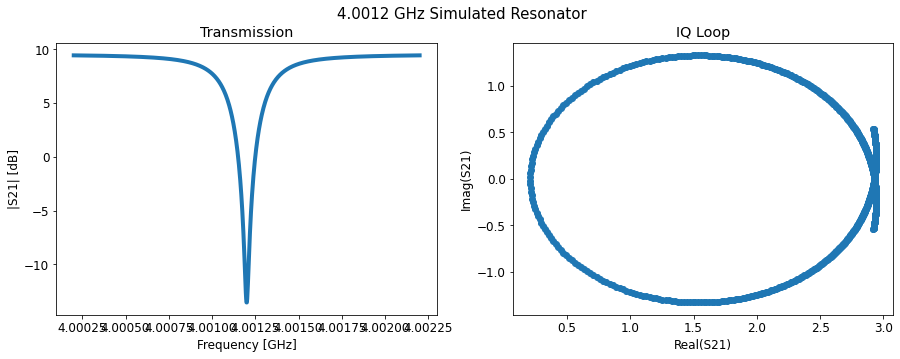

In [11]:
# Plot S21
sweep.plot_sweep()

# Single Photon Event

In [12]:
#Try just one photon and no TLS noise

def pulse(t, t0, tf=30):
    p = np.zeros_like(t)
    p[t >= t0] = np.exp(-(t[t >= t0] - t0) / tf)
    return p

t = np.linspace(0, 500, 1000)*1e-6  # in sec
photon = pulse(t, 20e-6, tf=30e-6)

qp_timestream_single = copy.deepcopy(quasiparticle_timestream)
qp_timestream_single.tvec = t
qp_timestream_single.data = photon

In [13]:
# Define Measurment Object
lit_res_measurment = ReadoutPhotonResonator(resonator, qp_timestream_single, freq, rf)

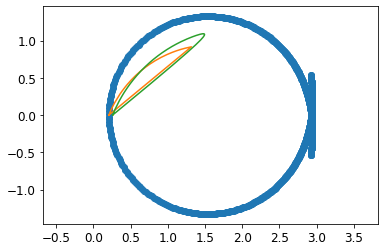

In [14]:
lit_res_measurment.plot_photon_response(sweep.s21)

In [15]:
theta1, d1 = lit_res_measurment.basic_coordinate_transformation()
theta2, d2 = lit_res_measurment.nick_coordinate_transformation()

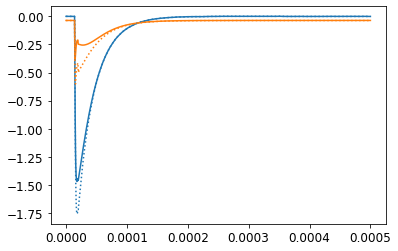

In [16]:
fig, axes = plt.subplots()
axes.plot(t, theta1, color='C0')
axes.plot(t, d1, color='C1')
axes.plot(t, theta2, linestyle=":", color='C0')
axes.plot(t, d2, linestyle=':', color='C1')

# Multiple Photons
Now I'm going to perform the same measurment but this time I will use the original `quasiparticle_timestream` object with many photons.

In [17]:
lit_res_measurment = ReadoutPhotonResonator(resonator, quasiparticle_timestream, freq, rf)

## Noise
### TLS Noise
TLS noise is intrinsic to the MKID device and is therefore a property of the `resonator`
### White Noise
White noise is broadband noise. Common sources include amplifiers and warm RF components.
### Line Noise
Line noise represents sources with narrow frequency bands, for example, another MKID resonator being driven nearby.


In [42]:
# toggle white noise and line noise
lit_res_measurment.noise_on = True

# adjust white noise scale
lit_res_measurment.rf.noise_scale = 10

# configure line noise
lit_res_measurment.rf.line_noise.freqs = ([60, 50e3, 100e3, 250e3, -300e3, 300e3, 500e3]) # Hz and relative to center of bin (MKID we are reading out)
lit_res_measurment.rf.line_noise.amplitudes = ([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.01])
lit_res_measurment.rf.line_noise.phases = ([0, 0.5, 0,1.3,0.5, 0.2, 2.4])

lit_res_measurment.rf.line_noise.freqs = ([500e3])
lit_res_measurment.rf.line_noise.amplitudes = ([0.00001])
lit_res_measurment.rf.line_noise.phases = ([0])


## Coordinate Transform

In [43]:
theta1, d1 = lit_res_measurment.basic_coordinate_transformation()
theta2, d2 = lit_res_measurment.nick_coordinate_transformation()

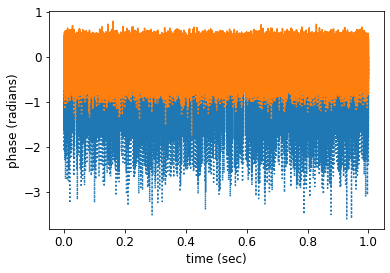

In [44]:
fig, axes = plt.subplots()
axes.plot(lit_res_measurment.photons.tvec, theta1, color='C0')
axes.plot(lit_res_measurment.photons.tvec, d1, color='C1')
axes.plot(lit_res_measurment.photons.tvec, theta2, linestyle=":", color='C0')
axes.plot(lit_res_measurment.photons.tvec, d2, linestyle=':', color='C1')
axes.set_xlabel('time (sec)')
axes.set_ylabel('phase (radians)');

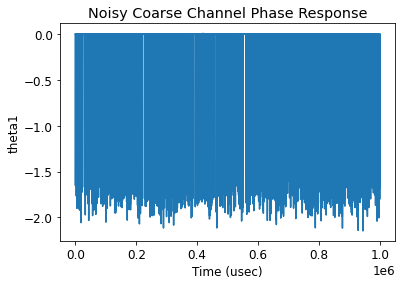

In [45]:
plt.plot(lit_res_measurment.photons.tvec*1e6, theta1)
plt.xlabel('Time (usec)')
plt.ylabel('theta1')
plt.title('Noisy Coarse Channel Phase Response');

(0.0, 300.0)

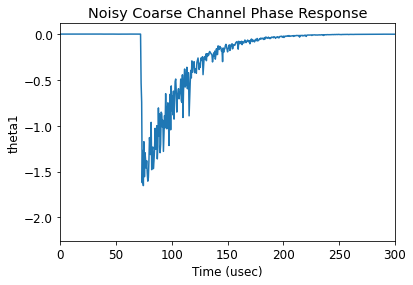

In [46]:
plt.plot(lit_res_measurment.photons.tvec*1e6, theta1)
plt.xlabel('Time (usec)')
plt.ylabel('theta1')
plt.title('Noisy Coarse Channel Phase Response');
plt.xlim([0,300])

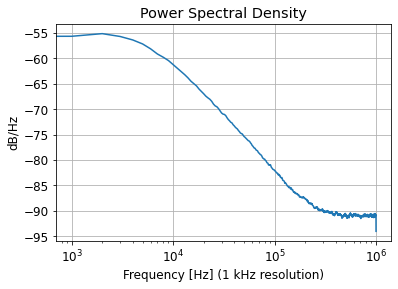

In [47]:
plot_psd(theta1, lit_res_measurment.photons.fs)

# Lowpass Filter


In [48]:
# Current 8-Tap Equirippple Lowpass Exported from MATLAB
coe = np.array([-0.08066211966627938, 0.02032901400427789, 0.21182262325068868, 0.38968583545138658, 0.38968583545138658, 0.21182262325068868, 0.02032901400427789, -0.08066211966627938])

In [49]:
fine_channel = apply_lowpass_filter(coe, theta1)

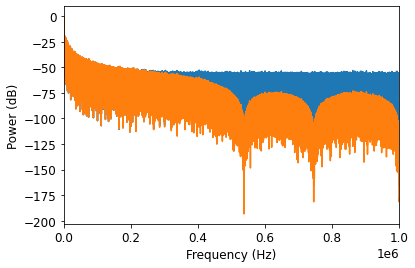

In [50]:
plot_channel_fft(theta1, lit_res_measurment.photons.fs)
plot_channel_fft(fine_channel, lit_res_measurment.photons.fs)
plt.xlim([0,1e6]);

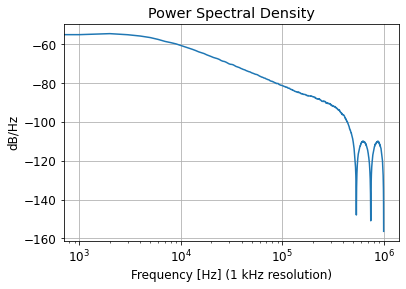

In [51]:
plot_psd(fine_channel, lit_res_measurment.photons.fs)

(0.0, 500.0)

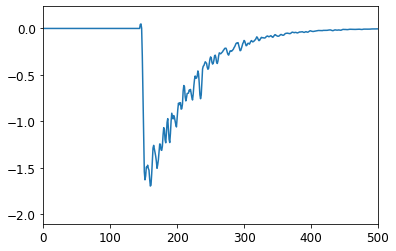

In [56]:
plt.plot(fine_channel)
plt.xlim([0,500])

# Optimal Filter

Now we want to use the optimal filter generation codebase on this simulated data to get an optimal filter for this resonator and  have it report information about that process.

array([ 2.44263195e-01,  7.14713458e-01,  1.01537989e+00,  1.07937667e+00,
        9.07589267e-01,  5.66819132e-01,  1.66956033e-01, -1.74902701e-01,
       -3.71117204e-01, -3.88686242e-01, -2.54974854e-01, -4.30109734e-02,
        1.57494816e-01,  2.72539891e-01,  2.68097025e-01,  1.58217454e-01,
       -4.82929867e-03, -1.53564165e-01, -2.32100541e-01, -2.16515724e-01,
       -1.21550355e-01,  8.04285129e-03,  1.17239185e-01,  1.63265246e-01,
        1.31932173e-01,  4.16511590e-02, -6.58620223e-02, -1.43845686e-01,
       -1.59930454e-01, -1.08758854e-01, -1.28114340e-02,  8.85465358e-02,
        1.56873256e-01,  1.71554911e-01,  1.38445831e-01,  8.63641330e-02,
        5.27253246e-02,  6.43408824e-02,  1.21768303e-01,  1.94530577e-01,
        2.30342698e-01,  1.75770761e-01,  7.53235744e-04, -2.82821989e-01,
       -6.16738719e-01, -9.09605427e-01, -1.06433697e+00, -1.01105302e+00,
       -7.33819135e-01, -2.81179633e-01])

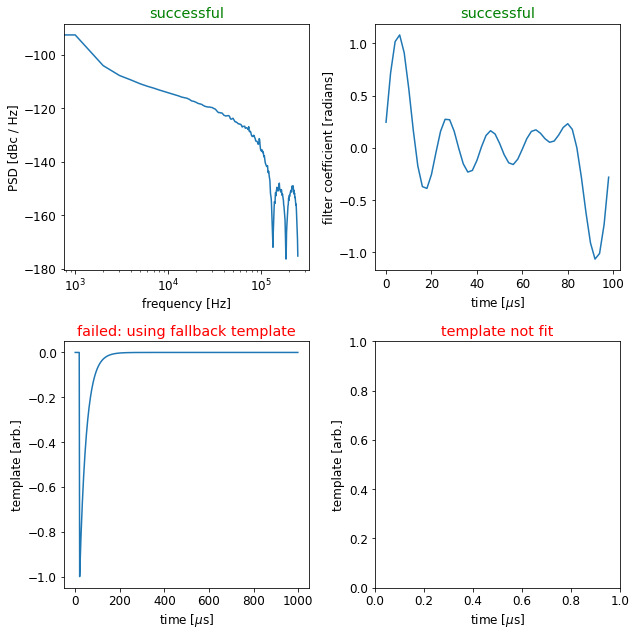

In [53]:
from mkidreadoutanalysis.optimal_filters.make_filters import Calculator
from mkidcore.config import ConfigThing
cfg=ConfigThing()
cfg.registerfromkvlist((('dt', 2e-6),
('summary_plot', True),
('pulses.unwrap', False),
('pulses.fallback_template', 'default'),
('pulses.ntemplate', 500),
('pulses.offset', 10),
('pulses.threshold', 4),
('pulses.separation', 50),
('pulses.min_pulses', 300),
('noise.nwindow', 500),
('noise.isolation', 100),
('noise.max_noise', 2000),
('template.percent', 80),
('template.cutoff', .1),
('template.min_tau', 5),
('template.max_tau', 100),
('template.fit', 'triple_exponential'),
('filter.filter_type',  'wiener'),
('filter.nfilter', 50),
('filter.normalize', True)), namespace='')

ofc = Calculator(fine_channel,  config=cfg, name='simulated')
ofc.calculate(clear=False)
ofc.plot()
ofc.result["filter"]

(25.0, 50.0)

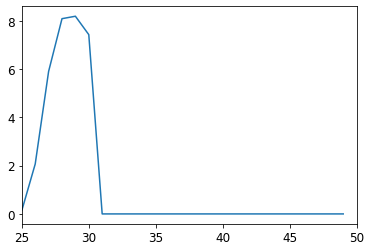

In [54]:
plt.plot(abs(np.fft.fftshift(np.fft.fft(ofc.result['filter']))))
plt.xlim([25,50])

## Apply Optimal Filter

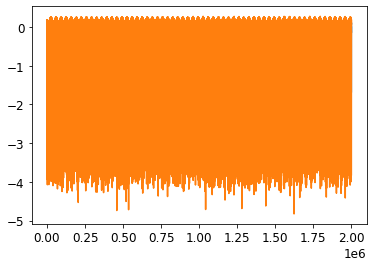

In [128]:
result = np.convolve(fine_channel, ofc.result["filter"])
result = result[:lit_res_measurment.photons.points]
plt.plot(fine_channel)
plt.plot(result)

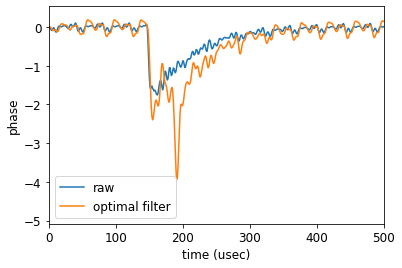

In [129]:
plt.plot(fine_channel)
plt.plot(result)
plt.xlim([0,500])
plt.ylabel('phase')
plt.xlabel('time (usec)')
plt.legend(['raw', 'optimal filter'])

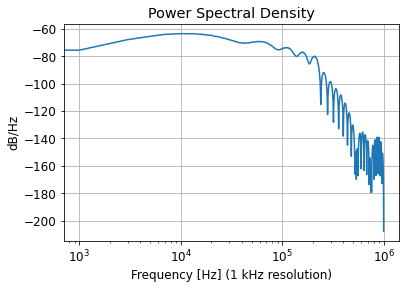

In [66]:
plot_psd(result, lit_res_measurment.photons.fs)

# Trigger

In [74]:
readout = MKIDReadout()
data = fine_channel
readout.trigger(lit_res_measurment.photons, data, threshold=-1.5, deadtime=30)

array([False, False, False, ..., False, False, False])

In [75]:
readout.record_energies(data)

array([-1.5838056 , -1.59683386, -1.61806385, ..., -1.60239615,
       -1.57815917, -1.59887565])

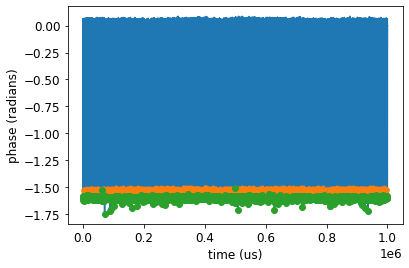

In [76]:
readout.plot_triggers(lit_res_measurment.photons, data, energies=True)
#plt.xlim([0,200])

# Compute Energy Resolution

52.151831775694426

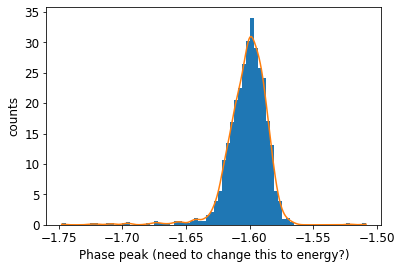

In [77]:
compute_r(readout.photon_energies, plot=True)